<h2>Findings on the MHP data set</h2>

In [21]:
#Import required packages
import pandas as pd
import numpy as np
# print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import seaborn as sns
%pylab inline
import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
#import pydotplus
import xlrd

Populating the interactive namespace from numpy and matplotlib


In [4]:
ccars = pd.read_excel('CCARs.xlsx')
services = pd.read_excel('Services.xlsx')

<h2> Question 1: Which patients are at the higher risk of re-hospitalization?</h2>

<h2>Finding 1</h2>

<h3>
<ul>
<li>Patients diagnosed with Bipolar Disorder and who are Homeless are at a higher risk of being re-hospitalized – <font color='blue'>22% of the total numbers of in-patients who are re-hospitalized within 1 to 90 days</font></li><br>
<li>Patients under Assisted Living are at a higher risk of being re-hospitalized - <font color='blue'>9% of the total numbers of in-patients who are re-hospitalized within 1 to 90 days</font></li>
</ul>
</h3>

<b>Approach:</b>

In [5]:
rh = services[services.SERVICE_TYPE == 'INPATIENT'].copy()
rh['PREV_DATE'] = rh['SERVICE_DATE']


<b>Shift date by 1 day</b>

In [6]:
def shiftdate(x):
    x.PREV_DATE = x.PREV_DATE.shift(1)
    return x

In [7]:
rh = rh.groupby(['CLIENT_ID'],as_index=False).apply(lambda x: shiftdate(x))

In [22]:
rh.head()

,CLIENT_ID,MBR_AGE,MBR_GENDER,MBR_PRIMARY_LANGUAGE,MBR_ZIPCODE,MEDICAID_ELIG_CAT,SERVICE_DATE,SERVICE_CODE,SERV_CODE_DESCRP,DIAGNOSIS,...,ADMISSION_DATE,DISCHARGE_DATE,PROVIDER,PRV_TYP_DESC,PROV_CREDENTIALS,PROV_ZIPCODE,PROV_FLAG,SOURCE,PREV_DATE,REHOSP_DAYS
8,8A3553A8A55A13,16,Female,ENGLISH,80304,CHILD,2015-01-01,0124,ROOM AND BOARD SEMI-PRIVATE PSYCHIATRIC,"Major Depressive Affective Disorder, Single Ep...",...,20141231,20150106,HIGHLANDS BEHAVIORAL HEALTH SYSTEM,PSYCHIATRIC FACILITY,NaN,80130,IPN Provider,Claim,NaT,0.0
9,67466476122112,51,Female,ENGLISH,80020,ADULT,2015-01-01,0124,ROOM AND BOARD SEMI-PRIVATE PSYCHIATRIC,"Major Depressive Affective Disorder, Recurrent...",...,20141230,20150103,UHS OF CENTENNIAL PEAKS LLC,GENERAL HOSPITAL,NaN,80027,IPN Provider,Claim,NaT,0.0
10,A691196A9AA912,52,Female,ENGLISH,80304,AwDC,2015-01-01,0124,ROOM AND BOARD SEMI-PRIVATE PSYCHIATRIC,"Major Depressive Affective Disorder, Recurrent...",...,20141229,20150103,UHS OF CENTENNIAL PEAKS LLC,GENERAL HOSPITAL,NaN,80027,IPN Provider,Claim,NaT,0.0
11,252AA252188113,14,Female,ENGLISH,80538,CHILD,2015-01-01,0124,ROOM AND BOARD SEMI-PRIVATE PSYCHIATRIC,"Major Depressive Affective Disorder, Recurrent...",...,20141228,20150105,HIGHLANDS BEHAVIORAL HEALTH SYSTEM,PSYCHIATRIC FACILITY,NaN,80130,IPN Provider,Claim,NaT,0.0
12,53199135833831,19,Male,ENGLISH,80303,FOSTER CARE,2015-01-01,0124,ROOM AND BOARD SEMI-PRIVATE PSYCHIATRIC,"Major Depressive Affective Disorder, Single Ep...",...,20141230,20150103,UHS OF CENTENNIAL PEAKS LLC,GENERAL HOSPITAL,NaN,80027,IPN Provider,Claim,NaT,0.0


<b>Calculate number of rehospitalization days</b>

In [8]:
rh['REHOSP_DAYS'] = rh['SERVICE_DATE'] - rh['PREV_DATE']

In [9]:
rh['REHOSP_DAYS'] = rh['REHOSP_DAYS'].dt.days

<b>Remove NaNs</b>

In [10]:
rh['REHOSP_DAYS'] = [0 if math.isnan(i) else i for i in rh.REHOSP_DAYS]

<b>Merge datasets</b>

In [12]:
rhcars = rh.merge(ccars)

<b>Retain one record per inpatient</b>

In [13]:
rhcars_dd = rhcars.drop_duplicates(subset=['SERVICE_DATE','CLIENT_ID'],keep='first')

<b>Considering only records when rehospitalization is > 0 days and <= 90 days</b>

In [14]:
rhcars_dd = rhcars_dd[(rhcars_dd.REHOSP_DAYS > 0) & (rhcars_dd.REHOSP_DAYS <= 90)]

<b>Considering RISK to be high when Rehospitalization days <= 10</b>

In [15]:
rhcars_dd['RISK'] = [1 if i<=10 else 0 for i in rhcars_dd.REHOSP_DAYS]

<b>Group related diagnoses together</b>

In [16]:
def changeDiag(dg):
    if "Adjustment Disorder" in dg:
        return "Adjustment Disorder"
    elif "Bipolar" in dg:
        return "Bipolar Disorder"
    elif "Schizo" in dg:
        return "Schizophrenia"
    elif "Depressive" in dg:
        return "Depressive Disorder"
    elif "Stress Disorder" in dg:
        return "Stress Disorder"
    elif "Stimulant Abuse" in dg:
        return "Stimulant Abuse"
    else:
        return dg

In [17]:
rhcars_dd['NEW_DIAGNOSIS'] = rhcars_dd['DIAGNOSIS'].apply(lambda x: changeDiag(x))

<b>So, this reduces number of diagnoses from 44 to 12</b>

In [18]:
len(rhcars_dd['NEW_DIAGNOSIS'].unique())
len(rhcars_dd['DIAGNOSIS'].unique())

12

44

In [19]:
rh_dgtree = rhcars_dd[['HOUSING','NEW_DIAGNOSIS','RISK']]
rh_dgtree = pd.get_dummies(data=rh_dgtree,columns=['NEW_DIAGNOSIS'])
rh_dgtree = pd.get_dummies(data=rh_dgtree,columns=['HOUSING'])

X = rh_dgtree.drop('RISK',axis=1)
Y = rh_dgtree['RISK']
dt = tree.DecisionTreeClassifier(max_depth=3)
dt.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [20]:
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 

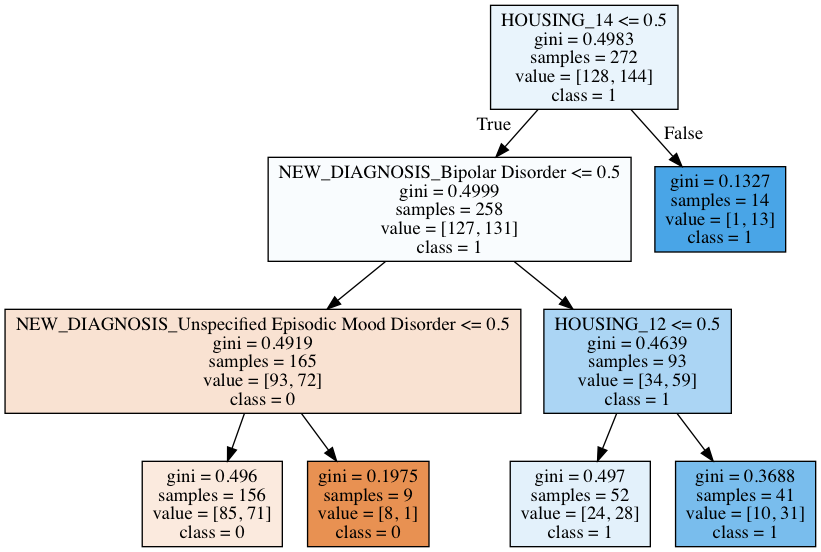

In [21]:
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

<h2>Let us validate our Finding 1</h2>

In [121]:
finding1 = rhcars_dd[rhcars_dd.RISK == 1]

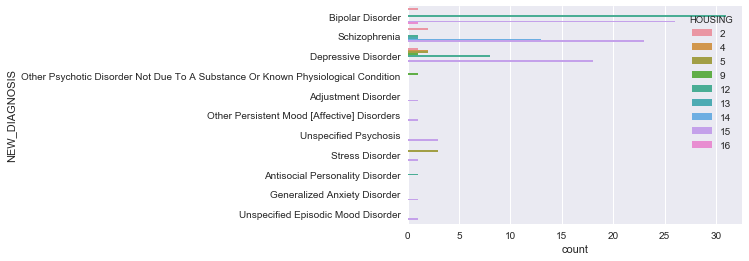

In [122]:
sns.countplot(y='NEW_DIAGNOSIS',hue='HOUSING',data=finding1)

<h2>Question 2:Which Services are converted into Claims?</h2>

<b>Populating the services and ccars tables</b>

<h2>Finding 2 - Part 1</h2>

<h3>The lower the number of Service Units the more likely a Service will be converted to Claim – <font color='blue'>63% of the total number of services under 1.5 service units were converted to Claims</font></h3>


In [123]:
#Convert the SOURCE column into 0 and 1
services['CLAIM']= [1 if i=='Claim' else 0 for i in services.SOURCE]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

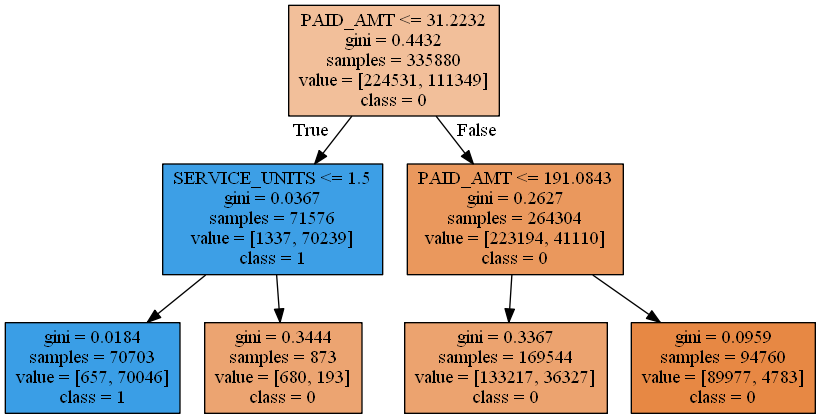

In [124]:
claimtree = services[['SERVICE_UNITS','CLAIM','PAID_AMT']].copy()

X = claimtree.drop('CLAIM',axis=1)
Y = claimtree['CLAIM']
dt = tree.DecisionTreeClassifier(max_depth=2)
dt.fit(X,Y)
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

<h3><font color='blue'>Why so?</font>
<ul>
<li>It is observed that when the number of service units is lower than 1.5, the paid amount for Claims is lesser than the paid amount for Encounters.</li>
<li>Also, when the number of service units is higher than 1.5, the paid amount for Claims is higher than the paid amount for Encounters.</li>
</ul>
</h3>

<b> When service units <= 1.5: </b>

In [125]:
services[(services.SERVICE_UNITS <= 1.5) & (services.CLAIM == 1)]['PAID_AMT'].mean()
services[(services.SERVICE_UNITS <= 1.5) & (services.CLAIM != 1)]['PAID_AMT'].mean()

55.330815760040686

161.52172159337348

<b> When service units > 1.5: </b>

In [126]:
services[(services.SERVICE_UNITS > 1.5) & (services.CLAIM == 1)]['PAID_AMT'].mean()
services[(services.SERVICE_UNITS > 1.5) & (services.CLAIM != 1)]['PAID_AMT'].mean()

538.69224248019088

213.93873688643626

<h2> Let us validate our finding 2 - Part 1 </h2>

In [127]:
finding2_1 = services[services.SERVICE_UNITS < 5]

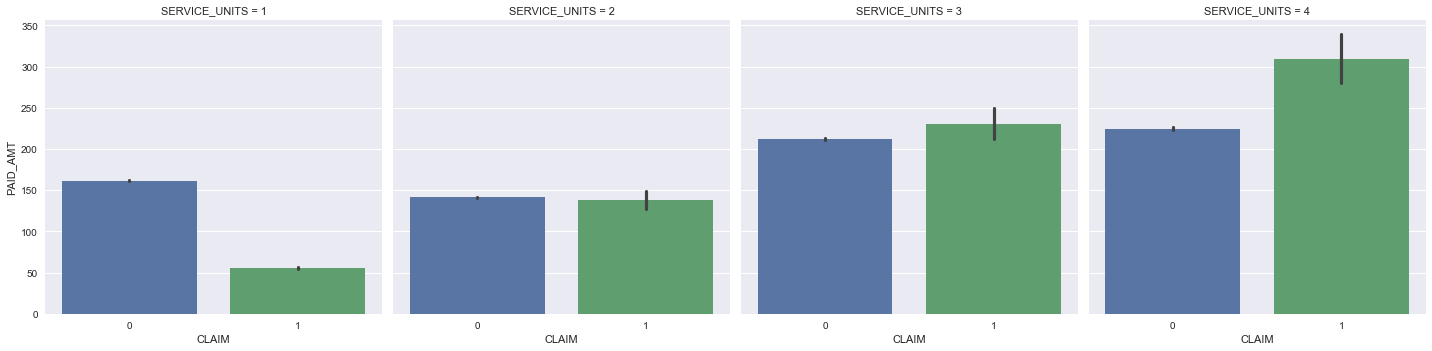

In [128]:
sns.factorplot(x='CLAIM',y='PAID_AMT',data=finding2_1,kind='bar',size=5,
              col='SERVICE_UNITS')

<h2>Finding 2 - Part 2 </h2>

<h3>
<ul>
<li>Services undertaken for Opioid Dependence Uncomplicated and with Service Units under 1.5 are most likely converted to Claims - <font color='blue'> 52% of the total number of services which are claims</font></li><br>
<li>Services undertaken for Opioid Dependence Continuous are most likely converted to Claims – <font color='blue'> 7% of the total number of services which are claims</font></li>
<ul>
</h3>

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

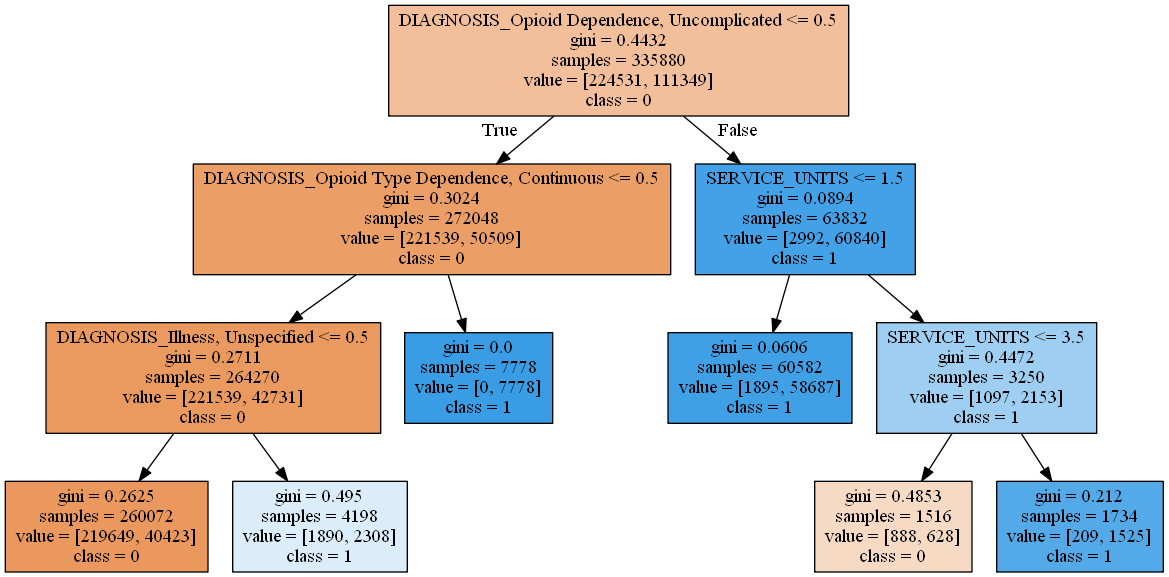

In [129]:
claimtree2 = services[['SERVICE_UNITS','DIAGNOSIS','CLAIM']]
claimtree2 = pd.get_dummies(data=claimtree2,columns=['DIAGNOSIS'])


X = claimtree2.drop('CLAIM',axis=1)
Y = claimtree2['CLAIM']
dt = tree.DecisionTreeClassifier(max_depth=3)
dt.fit(X,Y)
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

<h2>Let us validate our Finding 2 - Part 2</h2>

In [130]:
finding2_2=claimtree2.copy()
finding2_2['DIAG'] = [1 if (i=='Opioid Dependence, Uncomplicated') | (i == 'Opioid Type Dependence, Continuous') else 0 for i in services.DIAGNOSIS]
finding2_2=finding2_2[finding2_2.SERVICE_UNITS < 15]

In [131]:
claims = services[services.CLAIM == 1].copy()
claims['DIAG'] = [1 if (i=='Opioid Dependence, Uncomplicated') | (i == 'Opioid Type Dependence, Continuous') else 0 for i in claims.DIAGNOSIS]

In [132]:
claims['servicecut']= pd.cut(claims.SERVICE_UNITS,include_lowest=True, bins = [0,1.5,5,10,15,20,25,30,35,41])

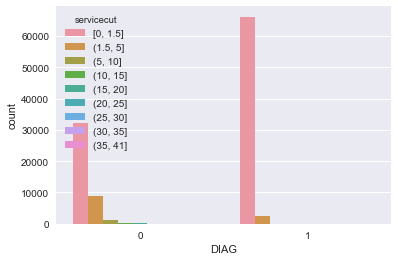

In [133]:
sns.countplot(x='DIAG',hue='servicecut',data=claims)

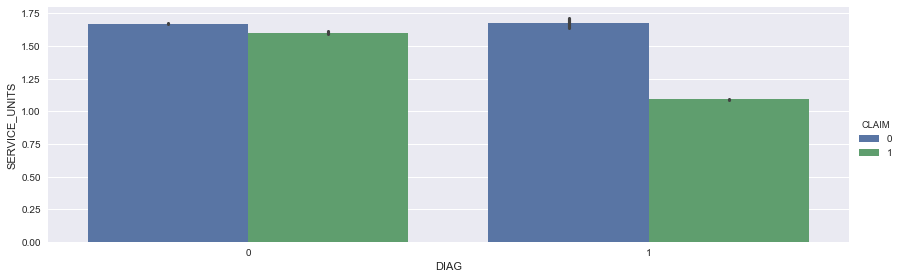

In [134]:
sns.factorplot(x='DIAG',y='SERVICE_UNITS',hue='CLAIM',data=finding2_2,aspect=3,kind='bar')